In [1]:
import os
import sys
import pprint

base_dir = 'F:\Thesis_ssd\MasterThesis3.0'
os.chdir(base_dir)

from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.DataGenerator import DataGenerator
from Classes.Modeling.Models import Models
from Classes.Modeling.RandomGridSearch import RandomGridSearch
from Classes.Modeling.CustomCallback import CustomCallback
from Classes.Modeling.ResultFitter import ResultFitter
from Classes.Scaling.ScalerFitter import ScalerFitter
from Classes.Scaling.MinMaxScalerFitter import MinMaxScalerFitter
from Classes.Scaling.StandardScalerFitter import StandardScalerFitter
import json

helper = HelperFunctions()
%load_ext tensorboard

In [2]:
load_args = {
    'earth_explo_only' : True,
    'noise_earth_only' : False,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 0.5,
    'seed' : 1,
    'subsample_size' : 0.25
}

loadData = LoadData(**load_args)

full_ds, train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)
dataGen = DataGenerator(loadData)


In [3]:
hyper_grid = {
        "batch_size" : [16, 32, 64, 128, 256, 512],
        "epochs" : [30, 33, 35],
        "learning_rate" : [0.1, 0.01, 0.001, 0.0001, 0.00001],
        "optimizer" : ["adam", "rmsprop", "sgd"]
    }
model_grid = {
    "start_neurons" : [16, 32, 64, 128, 256, 512, 1024],
    "dropout_rate" : [0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001, 0],
    "filters" : [11, 13, 15, 17, 19, 21, 23, 25, 27],
    "kernel_size" : [3, 5, 7, 9, 11, 13, 15],
    "padding" : ["same"],
    "l2_r" : [0.3, 0.2, 0.1, 0.01, 0.001, 0.0001],
    "l1_r" : [0.3, 0.2, 0.1, 0.01, 0.001, 0.0001],
    "activation" : ["relu", "sigmoid", "softmax", "tanh"],
    "output_layer_activation" : ["softmax", "sigmoid"]
}


model_nr = 6

use_time_augmentor = True
use_scaler = True
use_noise_augmentor = False
detrend = False
use_minmax = False
use_highpass = False
highpass_freq = 0.1

n_picks = 20

use_tensorboard = False
use_liveplots = True
use_custom_callback = False
use_early_stopping = True
start_from_scratch = True

randomGridSearch = RandomGridSearch(loadData, train_ds, val_ds, test_ds, model_nr, detrend, use_scaler, use_time_augmentor, 
                                    use_noise_augmentor, use_minmax, use_highpass, n_picks, hyper_grid = hyper_grid, 
                                    model_grid = model_grid, use_tensorboard = use_tensorboard,
                                    use_liveplots = use_liveplots, use_custom_callback = use_custom_callback,
                                    use_early_stopping = use_early_stopping, highpass_freq = highpass_freq,
                                    start_from_scratch = start_from_scratch)

In [4]:
def clear_tensorboard_dir():
    import os
    import shutil
    path = f"{base_dir}/Tensorboard_dir/fit"
    files = os.listdir(path)
    print(files)
    for f in files:
        shutil.rmtree(os.path.join(path,f))
if use_tensorboard:
    clear_tensorboard_dir()
    %tensorboard --logdir tensorboard_dir/fit

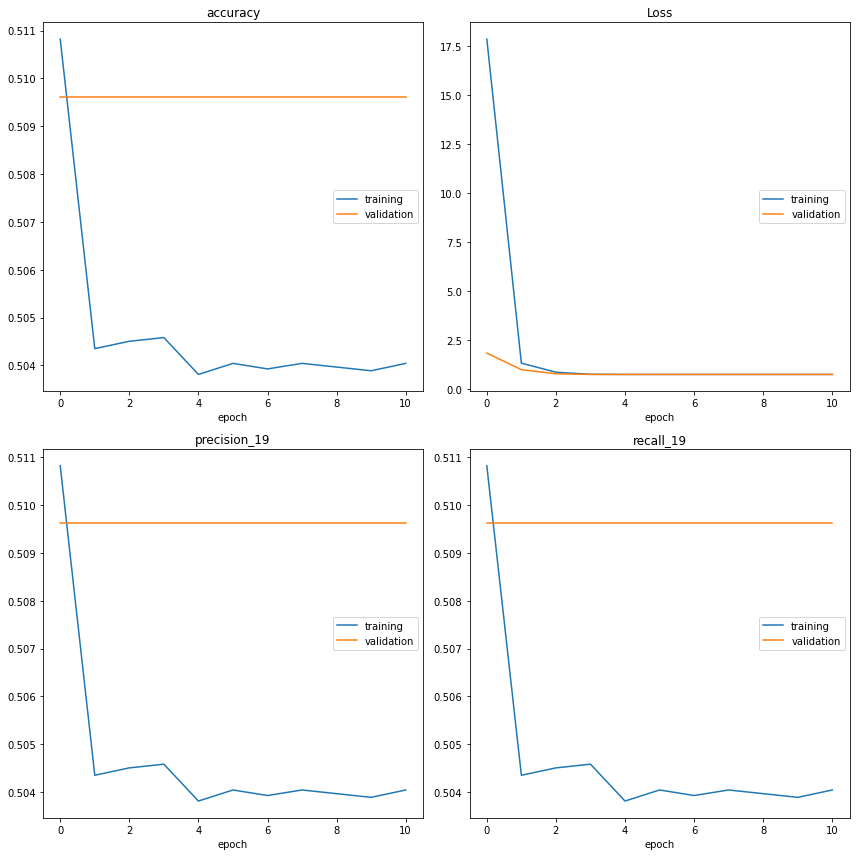

accuracy
	training         	 (min:    0.504, max:    0.511, cur:    0.504)
	validation       	 (min:    0.510, max:    0.510, cur:    0.510)
Loss
	training         	 (min:    0.741, max:   17.864, cur:    0.741)
	validation       	 (min:    0.740, max:    1.830, cur:    0.740)
precision_19
	training         	 (min:    0.504, max:    0.511, cur:    0.504)
	validation       	 (min:    0.510, max:    0.510, cur:    0.510)
recall_19
	training         	 (min:    0.504, max:    0.511, cur:    0.504)
	validation       	 (min:    0.510, max:    0.510, cur:    0.510)
Restoring model weights from the end of the best epoch.
1623/1623 [==============================] - 58s 36ms/step - loss: 0.7405 - accuracy: 0.5040 - precision_19: 0.5040 - recall_19: 0.5040 - val_loss: 0.7404 - val_accuracy: 0.5096 - val_precision_19: 0.5096 - val_recall_19: 0.5096
Epoch 00011: early stopping
----------------------------------------------------LOSS----------------------------------------------------------
Min val

In [5]:
results_df = randomGridSearch.fit()

In [7]:
results_df, min_loss, max_accuracy, max_precision, max_recall = results_df

In [8]:
max_accuracy_i = max_accuracy['val_index']
max_accuracy_i_train = max_accuracy['train_index']
max_precision_i = max_precision['val_index']
max_recall_i = max_recall['val_index']

In [9]:
results_df[results_df.columns[0:13]]

,batch_size,epochs,learning_rate,optimizer,activation,dropout_rate,filters,kernel_size,l1_r,l2_r,output_layer_activation,padding,start_neurons
0,256,33,1e-05,rmsprop,sigmoid,0.4,19,11,0.2,0.1,sigmoid,same,512
1,64,35,0.1,rmsprop,sigmoid,0.01,15,9,0.3,0.2,sigmoid,same,64
2,32,30,1e-05,sgd,softmax,0.01,15,13,0.001,0.001,softmax,same,512
3,16,35,0.01,adam,tanh,0.5,19,15,0.2,0.0001,sigmoid,same,512
4,512,35,0.0001,sgd,relu,0.001,15,11,0.01,0.01,sigmoid,same,256
5,512,33,0.1,rmsprop,sigmoid,0.01,23,5,0.1,0.1,sigmoid,same,16
6,128,35,0.01,rmsprop,tanh,0.01,13,9,0.2,0.0001,sigmoid,same,512
7,16,35,0.0001,rmsprop,sigmoid,0,27,15,0.3,0.0001,sigmoid,same,1024
8,16,30,0.1,adam,relu,0.01,23,9,0.1,0.2,sigmoid,same,256
9,32,33,0.01,rmsprop,tanh,0.2,23,13,0.2,0.01,softmax,same,16


**Max val accuracy**

In [10]:
model_accuracy = randomGridSearch.fit_from_index(results_df, max_accuracy_i)

softmax
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (32, 3, 17)               1530017   
_________________________________________________________________
conv1d_41 (Conv1D)           (32, 3, 8)                960       
_________________________________________________________________
batch_normalization_20 (Batc (32, 3, 8)                32        
_________________________________________________________________
flatten_20 (Flatten)         (32, 24)                  0         
_________________________________________________________________
dense_20 (Dense)             (32, 2)                   50        
Total params: 1,531,059
Trainable params: 1,531,043
Non-trainable params: 16
_________________________________________________________________


TypeError: generate_fit_args() got multiple values for argument 'use_tensorboard'

**Max train accuracy**

In [ ]:
model_accuracy_train = randomGridSearch.fit_from_index(results_df, max_accuracy_train_i)

**Max val precision**

In [ ]:
model_accuracy_train = randomGridSearch.fit_from_index(results_df, max_precision_i)

**Highest recall**

In [ ]:
model_recall = randomGridSearch.fit_from_index(results_df, max_recall_i)